In [1]:
import os
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dirpath = os.getcwd()
features_path = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), "udder_processing","features_dict")
features_file = "mfeature_table.csv"
df = pd.read_csv(os.path.join(features_path, features_file))
feature_names = df.columns[3:]
df[feature_names] = df[feature_names].apply(pd.to_numeric, errors='coerce')

C:\Users\marie\AppData\Local\Temp\ipykernel_23856\2098579829.py:4: DtypeWarning: Columns (21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(features_path, features_file))


In [12]:

feature_names 

Index(['udder_vol', 'lf_vol', 'rf_vol', 'lb_vol', 'rb_vol', 'udder_sarea',
       'lf_sarea', 'rf_sarea', 'lb_sarea', 'rb_sarea', 'lf_angle', 'rf_angle',
       'lb_angle', 'rb_angle', 'front_eu', 'back_eu', 'right_eu', 'left_eu',
       'front_gd', 'back_gd', 'right_gd', 'left_gd', 'udder_peri',
       'udder_area', 'udder_circ', 'udder_exc', 'lf_peri', 'lf_area',
       'lf_circ', 'lf_exc', 'rf_peri', 'rf_area', 'rf_circ', 'rf_exc',
       'lb_peri', 'lb_area', 'lb_circ', 'lb_exc', 'rb_peri', 'rb_area',
       'rb_circ', 'rb_exc', 'lf_len', 'rf_len', 'lb_len', 'rb_len'],
      dtype='object')

In [92]:
def list_columns(df, keyword):
    column_list = [col for col in df.columns if keyword in col]
    return column_list

def melt_frame(df, cols):
    selected_df = df[cols]
    melted_df = pd.melt(df, id_vars=['cow', 'frame'], value_vars=cols)
    return melted_df

def subset_df(df, keyword):
    kkword = '_' + keyword
    cols = list_columns(df, kkword)
    melted_df = melt_frame(df, cols)
    melted_df["variable"] = [val.replace(kkword, "") for val in melted_df["variable"]]
    return melted_df

def std(x): 
    return np.std(x)

def cv_plot(df, feature):
    fdf = subset_df(df, feature)
    gdf = fdf[['cow','variable', 'value']].groupby(['cow','variable']).agg([std, 'mean']).reset_index()
    gdf.columns = [c[1] if len(c[1])>0 else c[0] for c in gdf.columns]
    gdf["cv"] = gdf["std"] /gdf["mean"]
    gdf2 = fdf[['variable', 'value']].groupby(['variable']).agg([std, 'mean']).reset_index()
    gdf2.columns = [c[1]+ "_fg" if len(c[1])>0 else c[0] for c in gdf2.columns]
    gdf2["cv_fg"] = gdf2["std_fg"] /gdf2["mean_fg"]
    fig, ax = plt.subplots()
    sns.boxplot(y = gdf["cv"], x = gdf["variable"])
    sns.scatterplot(x = gdf["variable"], y = gdf2["cv_fg"], marker = "*", color = "red", s =100)
    plt.xlabel(feature)
    gdf= gdf.merge(gdf2, on = "variable", how = "left")
    
    return fig, gdf

def anova2_feature(df, feature):
    fdf = subset_df(df, feature)
    model = ols('value ~ C(variable) + C(cow) + C(variable):C(cow)', data=fdf).fit() 
    result = sm.stats.anova_lm(model, type=2)
    return result

def anova1_feature(df, feature):
    fdf = df[['cow', feature]]
    fdf.columns =['cow', 'value']
    model = ols('value ~ C(cow)', data=fdf).fit() 
    result = sm.stats.anova_lm(model, type=1)
    return result

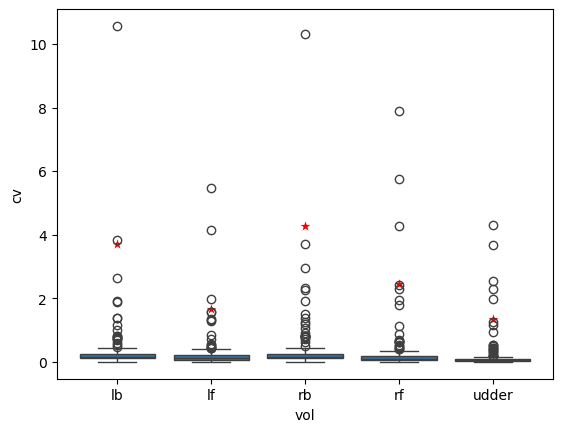

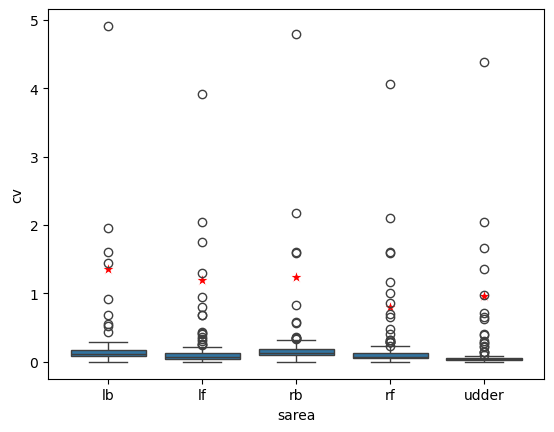

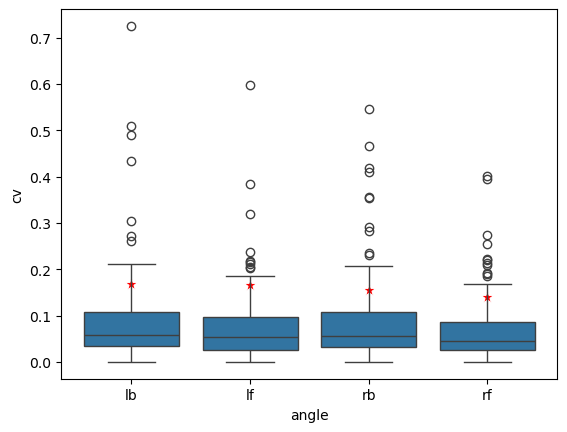

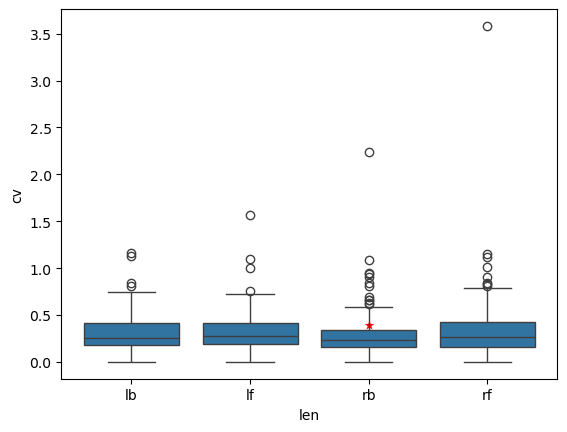

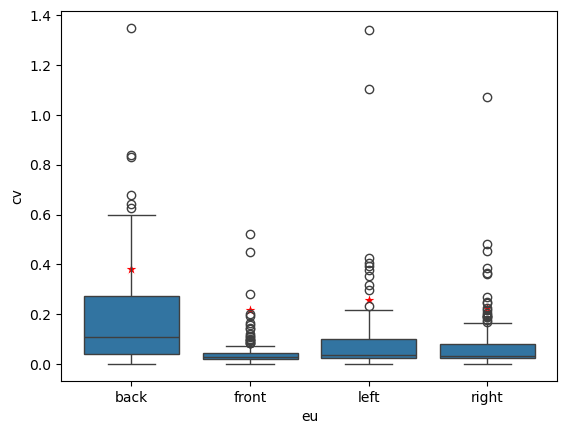

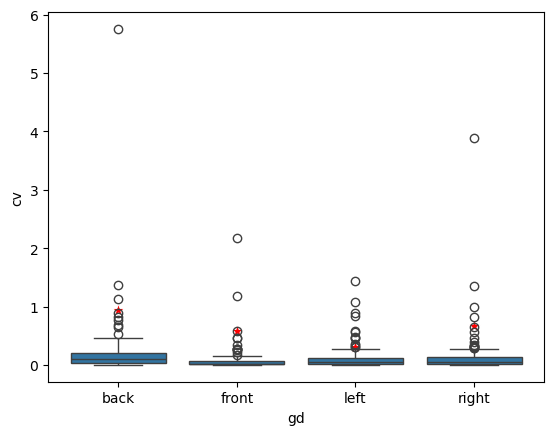

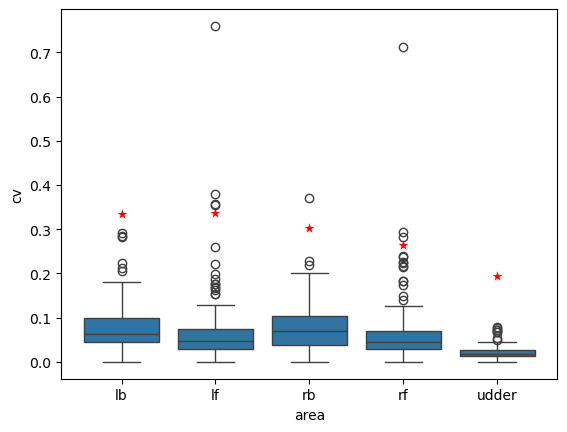

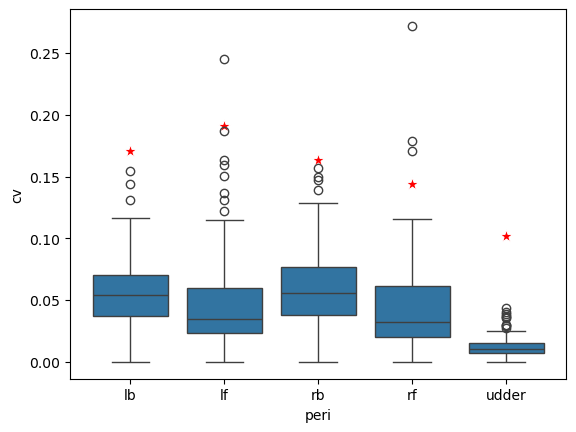

In [102]:
# by geoup of features
feature_list = ["vol", "sarea", "angle", "len", "eu", "gd", "area", "peri"]
df_cv = pd.DataFrame()
# foe each feacture calculate the mean
for feature in feature_list:
    plot_name = feature +"_cv.png"
    fig, gdf = cv_plot(df, feature)
    gdf["feature"] = feature 
    df_cv = pd.concat([df_cv, gdf], ignore_index = True)
    fig.savefig(os.path.join(r"cvs\plots", plot_name))

df_cv.to_csv(r"cvs\cv_all_features.csv", index = False)

In [84]:
anova_all = pd.DataFrame(index = feature_names, columns = ['df', 'sum_sq', 'mean_sq', 'F', 'PR(>F)'])
for feature in feature_names:
    results = anova1_feature(df, feature)
    anova_all.loc[feature] = results.loc['C(cow)'] 
anova_all.to_csv(r"cvs\ow_anova_all_features.csv", index = False)